<a href="https://colab.research.google.com/github/BunnyNoBugs/tiktok-analysis/blob/main/tiktok_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install sktime[all_extras]
!pip install prophet
!pip install orbit-ml
!pip install TikTokApi
!python -m playwright install

!sudo apt-get install libbrotli1\
    libnotify4\
    libwoff1\
    gstreamer1.0-plugins-base\
    libgstreamer1.0-0\
    libgstreamer-gl1.0-0\
    gstreamer1.0-plugins-bad\
    libenchant1c2a\
    libsecret-1-0\
    libhyphen0

  Using cached https://files.pythonhosted.org/packages/e3/e2/204c9c6beaf9e05ad28bd589c154afff35dffa6166d76841d3c0dec6c1e3/cmdstanpy-0.9.5-py3-none-any.whl
ERROR: prophet 1.0.1 has requirement cmdstanpy==0.9.68, but you'll have cmdstanpy 0.9.5 which is incompatible.
  Found existing installation: cmdstanpy 0.9.68
    Uninstalling cmdstanpy-0.9.68:
      Successfully uninstalled cmdstanpy-0.9.68
  Using cached https://files.pythonhosted.org/packages/08/b9/b4f0938b38dbe775c4def707f525ab816b9d0215ecd8ab2d76780f4514f8/cmdstanpy-0.9.68-py3-none-any.whl
ERROR: fbprophet 0.7.1 has requirement cmdstanpy==0.9.5, but you'll have cmdstanpy 0.9.68 which is incompatible.
  Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
Playwright build of chromium v888113 downloaded to /root/.cache/ms-playwright/chromium-888113
Playwright build of firefox v1271 downloaded to /root/.cache/ms-playwright/firefox-1271
Playwright build of webk

In [ ]:
import pandas as pd
from prophet import Prophet
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import mean_absolute_error
from orbit.diagnostics.plot import plot_predicted_data
from TikTokApi import TikTokApi

In [ ]:
!python '/content/drive/MyDrive/Colab Notebooks/tiktok_analysis/tiktoks_download.py'

hashtag: #popit
download successful!
tiktoks saved!


In [ ]:
tt_df = pd.read_json('/content/data/tiktoks_hashtag.json')
tt_df['createTime'] = pd.to_datetime(tt_df['createTime'], unit='s').dt.date
# tt_df = tt_df[tt_df['createTime'] >= pd.to_datetime('2021')]
tt_df['likes'] = tt_df['stats'].apply(lambda x: x['diggCount'])

In [ ]:
likes_df = pd.DataFrame(tt_df.groupby('createTime')['likes'].mean())
likes_df = likes_df.reset_index()
likes_df = likes_df.rename(columns={'createTime': 'ds', 'likes': 'y'})
likes_df['count'] = tt_df.groupby('createTime').size().to_numpy()

train_df, test_df = temporal_train_test_split(likes_df)

<AxesSubplot:>

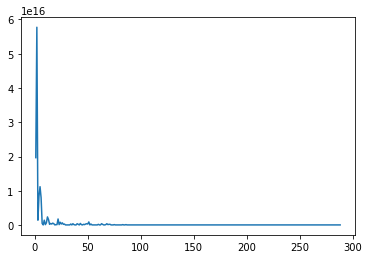

In [ ]:
# разница между тиктоками в днях
delta = likes_df['ds'] - likes_df.shift()['ds']
delta.plot()

In [ ]:
%%time

model = Prophet()
# model.add_regressor('count')
model.fit(train_df)
pred = model.predict(test_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CPU times: user 1.89 s, sys: 78.6 ms, total: 1.97 s
Wall time: 1.96 s


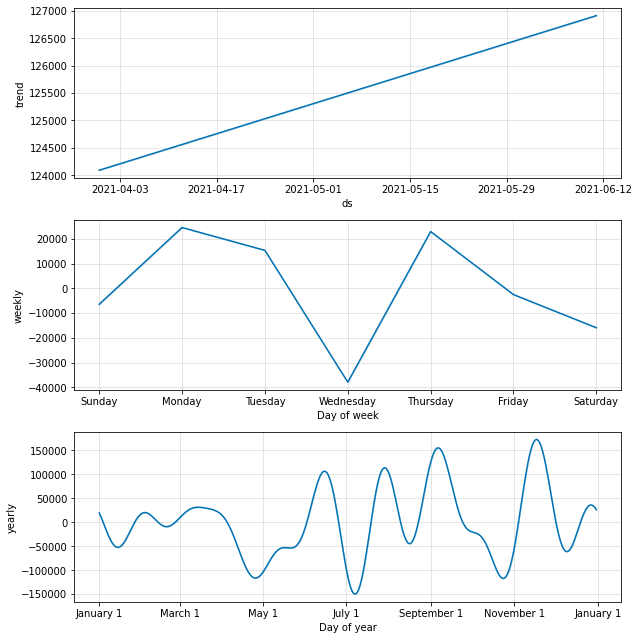

In [ ]:
model.plot_components(pred);

In [ ]:
pred = pred[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
pred = pred.rename(columns={'yhat': 'prediction', 'yhat_lower': 'prediction_5', 'yhat_upper': 'prediction_95'})

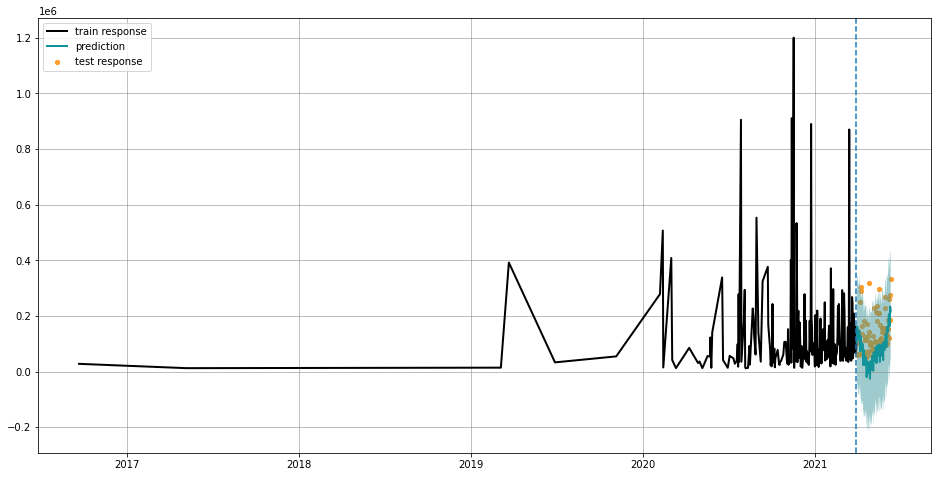

74737.70017049315


In [ ]:
plot_predicted_data(
    training_actual_df=train_df, predicted_df=pred,
    date_col='ds', actual_col='y',
    test_actual_df=test_df,
    insample_line=True
)
print(mean_absolute_error(pred['prediction'], test_df['y']))

In [ ]:
pred_values = pred['prediction']

In [ ]:
pred_values.index = pd.Int64Index(pred_values.index)
pred_values.index += len(train_df)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='y'>)

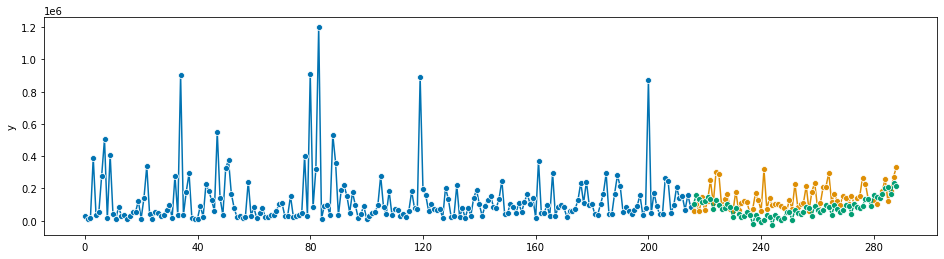

In [ ]:
plot_series(train_df['y'], test_df['y'], pred_values)